<a href="https://colab.research.google.com/github/rickituri98/Fault_Classifier_CNN/blob/master/CNN_Training_Tv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training and Validation Proccess - Convolutional Neural Network

In [1]:
!npx degit rickituri98/Fault_Classifier_CNN/Outputs_Data_Handling -f

npx: installed 1 in 2.781s
> destination directory is not empty. Using --force, continuing
> cloned rickituri98/Fault_Classifier_CNN#master


## Importing dataset and modules

In [2]:
import zipfile
with zipfile.ZipFile("/content/Training&Test_set.zip","r") as zip_ref:
    zip_ref.extractall()

In [3]:
!pip install -q pyyaml h5py
import scipy.io as sio
import matplotlib.pyplot as plt
import time
import os
import numpy as np

TrainTest_dict = sio.loadmat('/content/Training&Test_set.mat')
X_trainset = TrainTest_dict.get("X_train")
Y_trainset = TrainTest_dict.get("Y_train")
X_testset = TrainTest_dict.get("X_test")
Y_testset = TrainTest_dict.get("Y_test")
print(type(TrainTest_dict), type(X_trainset), type(Y_trainset), len(Y_trainset))

<class 'dict'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> 471


In [5]:
print(X_trainset.shape, Y_testset.shape)

(471, 2943, 3) (201, 1)


ONE HOT ENCODING - Y Labels

In [16]:
from keras.utils import to_categorical
Y_trainset = Y_trainset.reshape((len(Y_trainset),))
Y_testset = Y_testset.reshape((len(Y_testset),))
Y_trainvalues = np.array(Y_trainset)
Y_testvalues = np.array(Y_testset)
Y_onehot_train = to_categorical(Y_trainvalues)
Y_onehot_test = to_categorical(Y_testvalues)

## devolver a la forma inicial de Y label
inverted = np.argmax(Y_onehot_train[10]) # se varía el num de evento
print(inverted)

1


In [18]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv1D
from keras.layers import MaxPooling1D, Dropout, GlobalMaxPooling1D
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.utils import layer_utils
from keras.utils import plot_model
from keras.optimizers import Adam
tf.__version__

'2.3.0'

## Defining Hyperparameters

In [19]:
batch_size = 24                     # Batch size
seq_len = X_trainset[0].shape[0]          # Number of steps
X_input_shape = X_trainset[0].shape
learning_rate = 0.0001
epochs = 100
n_classes = 5
n_channels = 3
activation ='relu'
loss = 'categorical_crossentropy'
#X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_trainset, Y_trainset, stratify = Y_trainset, random_state = 123)
#print(X_input_shape, X_trainset.shape[1:])

## Model Creation

In [20]:
def model(input_shape):
  X_input = Input(input_shape, name ='Input')

  #First Multi-Layer: CONV->RELU
  X = Conv1D(filters=18, kernel_size=2, strides=1, padding='same', name ='conv0', activation = activation)(X_input)
  X = MaxPooling1D(pool_size=2, strides=2, padding='same', name ='pool0')(X)

  # Second Multi-Layer: CONV->RELU
  X = Conv1D(filters=36, kernel_size=2, strides=1, padding='same', name ='conv1', activation = activation)(X)
  X = MaxPooling1D(pool_size=2, strides=2, padding='same', name ='pool1')(X)

  # Third Multi-Layer: CONV->RELU
  X = Conv1D(filters=72, kernel_size=2, strides=1, padding='same', name ='conv2', activation = activation)(X)
  X = MaxPooling1D(pool_size=2, strides=2, padding='same', name ='pool2')(X)

  # Fourth Multi-Layer: CONV->RELU
  X = Conv1D(filters=144, kernel_size=2, strides=1, padding='same', name ='conv3', activation = activation)(X)
  X = MaxPooling1D(pool_size=2, strides=2, padding='same', name ='pool3')(X)

  # Fully Connected Layer
  X_Flatten = Flatten(name ='Flatten_0')(X)
  #X_Dense = Dense(X.shape[1]*X.shape[2], activation=activation, name='fully_connected_layer')(X_Flatten)
  #X_Dropout = Dropout(0.5, name ='dropout')(X_Dense)
  X_Dropout = Dropout(0.5, name ='dropout')(X_Flatten)
  # Prediction
  X_Output = Dense(n_classes, activation='softmax',  name ='Classifier')(X_Dropout)

  model = Model(inputs=X_input, outputs=X_Output, name = 'Fault_Classifier')
  adam = Adam(lr=learning_rate)
  model.compile(optimizer=adam, loss=loss, metrics=['acc', 'mse', 'mae'])
  model.summary()
  
  return model

Fault_model = model(X_input_shape)

Model: "Fault_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 2943, 3)]         0         
_________________________________________________________________
conv0 (Conv1D)               (None, 2943, 18)          126       
_________________________________________________________________
pool0 (MaxPooling1D)         (None, 1472, 18)          0         
_________________________________________________________________
conv1 (Conv1D)               (None, 1472, 36)          1332      
_________________________________________________________________
pool1 (MaxPooling1D)         (None, 736, 36)           0         
_________________________________________________________________
conv2 (Conv1D)               (None, 736, 72)           5256      
_________________________________________________________________
pool2 (MaxPooling1D)         (None, 368, 72)      

## Model Training

In [21]:
history = Fault_model.fit(x = X_trainset, y = Y_onehot_train, epochs = epochs, batch_size = batch_size)

Epoch 1/100
20/20 [==============================] - 2s 112ms/step - loss: 1.5257 - acc: 0.5223 - mse: 0.1529 - mae: 0.3117
Epoch 2/100
20/20 [==============================] - 2s 115ms/step - loss: 1.3295 - acc: 0.5945 - mse: 0.1343 - mae: 0.2812
Epoch 3/100
20/20 [==============================] - 2s 114ms/step - loss: 1.2425 - acc: 0.5945 - mse: 0.1258 - mae: 0.2424
Epoch 4/100
20/20 [==============================] - 2s 115ms/step - loss: 1.2034 - acc: 0.5945 - mse: 0.1217 - mae: 0.2426
Epoch 5/100
20/20 [==============================] - 2s 115ms/step - loss: 1.1678 - acc: 0.5945 - mse: 0.1183 - mae: 0.2467
Epoch 6/100
20/20 [==============================] - 2s 115ms/step - loss: 1.1388 - acc: 0.5945 - mse: 0.1159 - mae: 0.2323
Epoch 7/100
20/20 [==============================] - 2s 115ms/step - loss: 1.0981 - acc: 0.5945 - mse: 0.1114 - mae: 0.2381
Epoch 8/100
20/20 [==============================] - 2s 115ms/step - loss: 1.0420 - acc: 0.5987 - mse: 0.1063 - mae: 0.2211
Epoch 9/

## Model performance

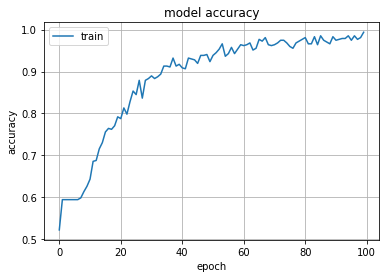

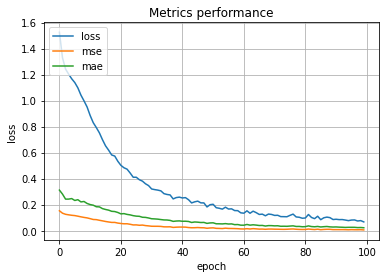

In [22]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.grid()
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['mse'])
plt.plot(history.history['mae'])
plt.title('Metrics performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'mse', 'mae'], loc='upper left')
plt.grid()
plt.show()

## Model Validation

In [23]:
preds = Fault_model.evaluate(x = X_testset, y = Y_onehot_test)
### END CODE HERE ###
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

7/7 [==============================] - 0s 38ms/step - loss: 0.0731 - acc: 0.9851 - mse: 0.0066 - mae: 0.0229

Loss = 0.07310604304075241
Test Accuracy = 0.9850746393203735


## Final Stage: Exporting Trained Model

In [35]:
# Scheme model in png
from keras.utils import plot_model
plot_model(Fault_model, to_file='./model.png', show_shapes=True,)
# Save the entire model to a HDF5 file.
Fault_model.save('Fault_Classifier_model.h5')


Predicción de muestras

In [32]:
from sklearn.metrics import confusion_matrix
x_1 = X_testset[10]
y_1 = Y_testset[10]
print(x_1.shape,y_1)
Y_predict = []
Y_onehot_pred = Fault_model.predict(X_testset)
for k in range(len(X_testset)):
  Y_predict.append(np.argmax(Y_onehot_pred[k])) # se varía el num de evento
print(np.array(Y_predict).shape, Y_testset.shape)

cm = confusion_matrix(Y_testset, np.array(Y_predict))
cm_norm =  cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#print(np.round(Fault_model.predict(X_testset)[10]).shape)

(2943, 3) 3
(201,) (201,)


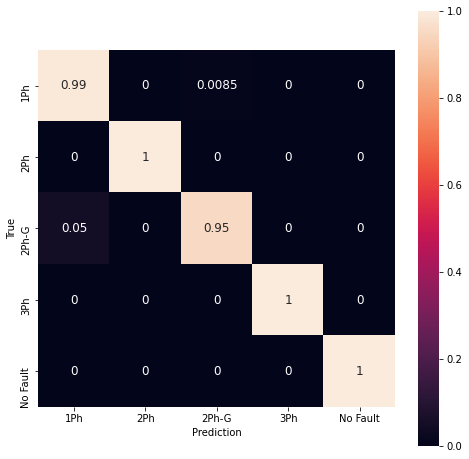

In [37]:
import seaborn as sns
import pandas as pd
df_cm = pd.DataFrame(cm_norm, ["1Ph", "2Ph", "2Ph-G", "3Ph", "No Fault"], ["1Ph", "2Ph", "2Ph-G", "3Ph", "No Fault"])
plt.figure(figsize = (8,8))
conf = sns.heatmap(df_cm, annot=True, square=True, annot_kws={"size": 12})
conf.set_xlabel('Prediction')
conf.set_ylabel('True')
plt.savefig('confusion_matrix.png')